In [0]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!nvidia-smi

Mon Jan 21 18:17:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    68W / 149W |    116MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
!ls

sample_data


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [11]:
!ls

kaggle.json  sample_data


In [0]:
!cp kaggle.json ~/.kaggle/

In [13]:
#!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!kaggle datasets download -d hasibzunair/malaria

100% 812M/815M [00:13<00:00, 40.9MB/s]
100% 815M/815M [00:13<00:00, 61.9MB/s]


In [14]:
!ls

kaggle.json  malaria.zip  sample_data


In [0]:
os.listdir()

['.config', 'kaggle.json', 'malaria.zip', 'sample_data']

In [15]:
!unzip 'malaria.zip'

Archive:  malaria.zip
  inflating: y_test.npy              
  inflating: x_test.npy              
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: x_train.npy             
  inflating: x_val.npy               


In [0]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
# see RAM usage
def spec():
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

In [0]:
spec()

Gen RAM Free: 9.8 GB  | Proc size: 3.4 GB
GPU RAM Free: 11325MB | Used: 116MB | Util   1% | Total 11441MB


In [16]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [17]:
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [18]:
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [0]:
spec()

Gen RAM Free: 6.5 GB  | Proc size: 6.7 GB
GPU RAM Free: 11325MB | Used: 116MB | Util   1% | Total 11441MB


In [19]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


# Data loaded!

In [20]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [21]:
# model with ALL layers frozen, except for the SOFTMAX layer
def vgg16():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    #dense = Dense(256, activation='relu')(X)
    #dropout_layer = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax')(X)
    
    # magical line of freezing layers
    #for layer in base_model.layers:
        #layer.trainable=False

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy']) ##metrics=[precision,recall, f1])
    return model

model=vgg16()
model.summary()

58892288/58889256 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool

In [22]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [29]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
|rm -f vgg_a.h5

In [30]:
model=vgg16()
path_model='vgg_a.h5'  

# set the learning rate
K.set_value(model.optimizer.lr, 0.0001) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=30, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

# when training few params, VERY SMALL learning rate does not work

Train on 22046 samples, validate on 2756 samples
Epoch 1/30
22046/22046 [==============================] - 507s 23ms/step - loss: 0.8277 - acc: 0.6917 - val_loss: 0.5091 - val_acc: 0.8052
Epoch 2/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.3877 - acc: 0.8514 - val_loss: 0.3244 - val_acc: 0.8817
Epoch 3/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.2741 - acc: 0.9022 - val_loss: 0.2555 - val_acc: 0.9093
Epoch 4/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.2279 - acc: 0.9226 - val_loss: 0.2213 - val_acc: 0.9224
Epoch 5/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.2034 - acc: 0.9327 - val_loss: 0.2009 - val_acc: 0.9351
Epoch 6/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.1877 - acc: 0.9381 - val_loss: 0.1865 - val_acc: 0.9405
Epoch 7/30
22046/22046 [==============================] - 505s 23ms/step - loss: 0.1763 - acc: 0.9429 - val_loss: 0.1

In [0]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()

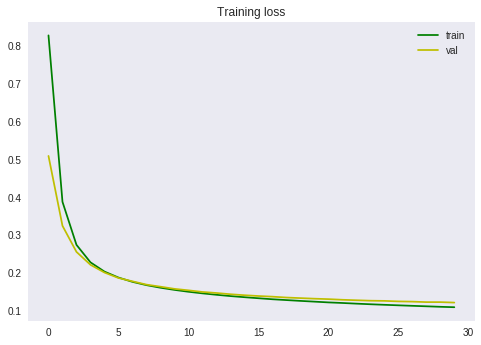

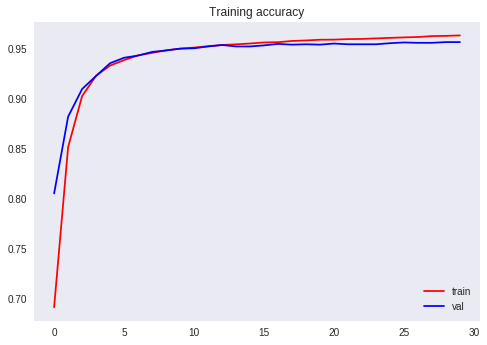

In [32]:
plot_loss_accu(h)

In [33]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1501916478258248
Test accuracy: 0.9477503628447025


| Experiments | Train | Val  | Test | Others 
|------|------|------|------|------|
|   Softmax layer train | 93.52 | 93.61 |  93.06 | VGG16
|   All layer train   | 96.28| 95.61   | 94.77  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx| xx   | xx  | VGG16
|   VGG   | xx | xx  | xx  | VGG16
|   VGG   | xx| xx   | xx  | VGG16

# Using model.predict(test)

In [0]:
y_pred = model.predict(x_test)
y_pred.shape

(2756, 2)

In [0]:
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
pred_labels.shape

0

In [0]:
#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
y_test.shape

(2756,)

In [0]:
# check shape for ground truth and predicted labels
y_test.shape, pred_labels.shape

((2756,), (2756,))

In [0]:
print('Accuracy: ',np.mean((y_test==pred_labels)))

Accuracy:  0.9306966618287373
